In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm.keras import TqdmCallback
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras.applications import resnet50
from keras.models import *
from keras.layers import *
import keras
import warnings
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3, preprocess_input
warnings.filterwarnings('ignore')

**Mounting with Google Drive and Extracting the files**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
from tqdm.notebook import tqdm

zip_path = '/content/drive/My Drive/cell_images.zip'
extract_to = '/content/cell_images'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    files_list = zip_ref.infolist()
    with tqdm(total=len(files_list), desc="Extracting files") as pbar:
        for file in files_list:
            zip_ref.extract(member=file, path=extract_to)
            pbar.update(1)

Extracting files:   0%|          | 0/55128 [00:00<?, ?it/s]

In [ ]:
!ls "/content/cell_images/cell_images"

Parasitized  Uninfected


In [ ]:
def data_prep(parasitized_path, uninfected_path):
    parasitized_files = [f for f in os.listdir(parasitized_path) if not f.startswith('.')]
    uninfected_files = [f for f in os.listdir(uninfected_path) if not f.startswith('.')]

    parasitized = [os.path.join(parasitized_path, f) for f in parasitized_files]
    uninfected = [os.path.join(uninfected_path, f) for f in uninfected_files]

    labels = ['parasitized'] * len(parasitized) + ['uninfected'] * len(uninfected)
    data = parasitized + uninfected

    return pd.DataFrame({'Image_Path': data, 'Labels': labels})

parasitized_path = '/content/cell_images/cell_images/Parasitized'
uninfected_path = '/content/cell_images/cell_images/Uninfected'

df = data_prep(parasitized_path, uninfected_path)
print(df.head())

                                          Image_Path       Labels
0  /content/cell_images/cell_images/Parasitized/C...  parasitized
1  /content/cell_images/cell_images/Parasitized/C...  parasitized
2  /content/cell_images/cell_images/Parasitized/C...  parasitized
3  /content/cell_images/cell_images/Parasitized/C...  parasitized
4  /content/cell_images/cell_images/Parasitized/C...  parasitized


Displaying 5 Parasitized Images: 


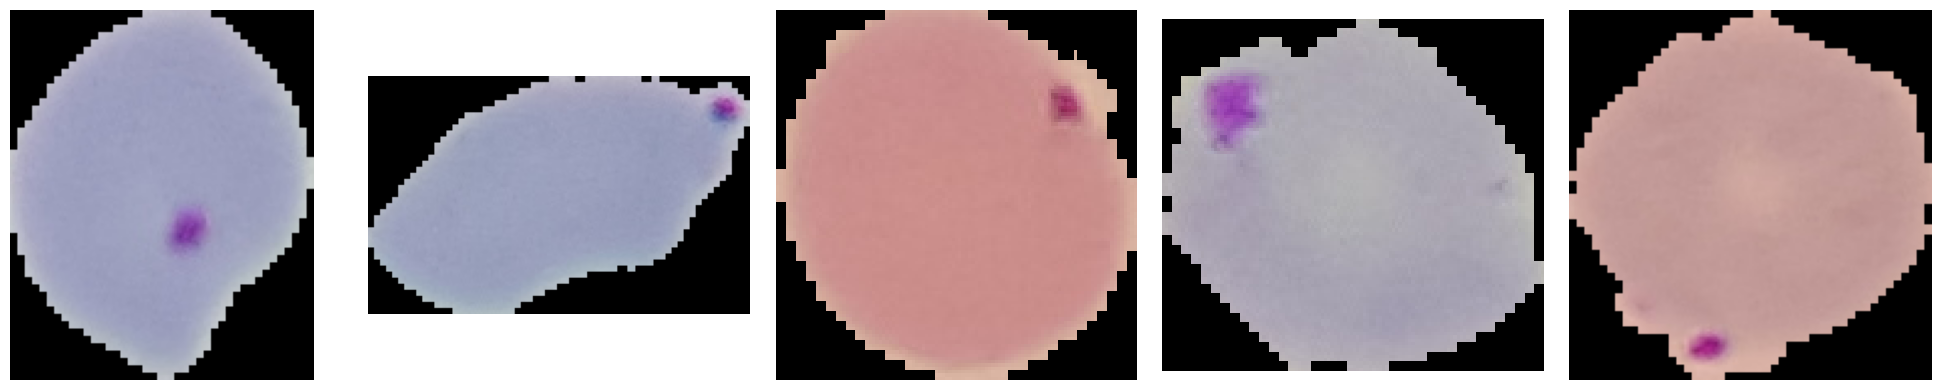


Displaying 5 Uninfected Images: 


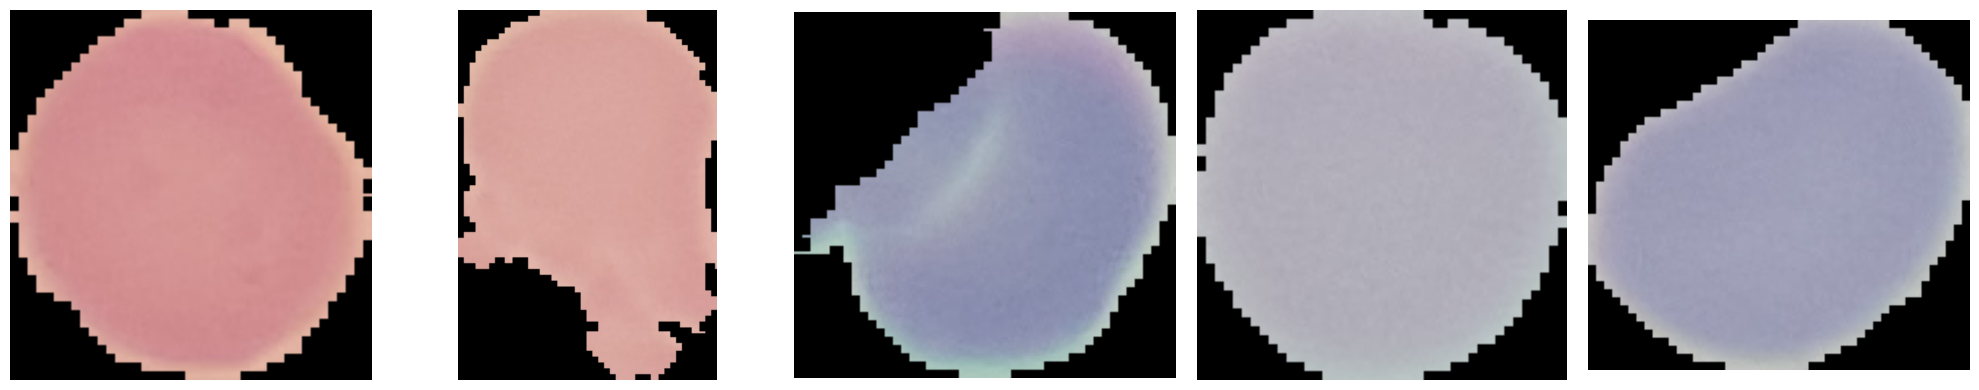

In [ ]:
print("Displaying 5 Parasitized Images: ")
plt.figure(figsize=(20, 4))
for i in range(5):
    img_path = df[df['Labels'] == 'parasitized']['Image_Path'].iloc[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

print("\nDisplaying 5 Uninfected Images: ")
plt.figure(figsize=(20, 4))
for i in range(5):
    img_path = df[df['Labels'] == 'uninfected']['Image_Path'].iloc[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
label_counts = df['Labels'].value_counts()
print(label_counts)

parasitized    13779
uninfected     13779
Name: Labels, dtype: int64


**Data Preparation and Model Callback Setup for Image Classification**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

train, test = train_test_split(df, test_size=0.20)

In [ ]:
img_datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2
)

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
train_generator = img_datagen.flow_from_dataframe(
    dataframe = train,
    directory = None,
    x_col = 'Image_Path',
    y_col = 'Labels',
    target_size = (128, 128),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    subset = 'training'
)

validation_generator = img_datagen.flow_from_dataframe(
    dataframe = train,
    directory = None,
    x_col = 'Image_Path',
    y_col = 'Labels',
    target_size = (128, 128),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    subset = 'validation'
)

Found 17637 validated image filenames belonging to 2 classes.
Found 4409 validated image filenames belonging to 2 classes.


**Visualizing Model Performance Metrics**

In [ ]:
def plot_model_performance_metrics(model_history):
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    precision_key = next((k for k in model_history.history.keys() if k.startswith('precision')), None)
    val_precision_key = next((k for k in model_history.history.keys() if k.startswith('val_precision')), None)
    recall_key = next((k for k in model_history.history.keys() if k.startswith('recall')), None)
    val_recall_key = next((k for k in model_history.history.keys() if k.startswith('val_recall')), None)

    plt.figure(figsize = (20, 10))

    plt.subplot(2, 3, 1)
    plt.plot(accuracy, label = 'Training Accuracy')
    plt.plot(val_accuracy, label = 'Validation Accuracy')
    plt.title('Accuracy: Training vs. Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(loss, label = 'Training Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.title('Loss: Training vs. Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if precision_key and val_precision_key:
        precision = model_history.history[precision_key]
        val_precision = model_history.history[val_precision_key]
        plt.subplot(2, 3, 3)
        plt.plot(precision, label = 'Training Precision')
        plt.plot(val_precision, label = 'Validation Precision')
        plt.title('Precision: Training vs. Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

    if recall_key and val_recall_key:
        recall = model_history.history[recall_key]
        val_recall = model_history.history[val_recall_key]
        plt.subplot(2, 3, 4)
        plt.plot(recall, label = 'Training Recall')
        plt.plot(val_recall, label = 'Validation Recall')
        plt.title('Recall: Training vs. Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

    plt.tight_layout()
    plt.show()

**Building CNN**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def cnn_model(df, train, test, my_callbacks):
    x_train = img_datagen.flow_from_dataframe(
        dataframe = train,
        x_col = 'Image_Path',
        y_col = 'Labels',
        class_mode = 'binary',
        target_size = (134, 134),
        shuffle = True,
        batch_size = 10,
        seed = 10,
        subset = 'training')

    x_test = img_datagen.flow_from_dataframe(
        dataframe = test,
        x_col = 'Image_Path',
        y_col = 'Labels',
        class_mode = 'binary',
        target_size = (134, 134),
        shuffle = False,
        batch_size = 10,
        seed = 10)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu',
                               padding = 'same',
                               input_shape = (134, 134, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3, 3),
                               activation = 'relu',
                               padding = 'same'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3),
                               activation = 'relu',
                               padding = 'same'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy',
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.Recall()])

    cnn_model_history = model.fit(
        x_train,
        steps_per_epoch = len(x_train),
        epochs = 5,
        validation_data = x_test,
        validation_steps = len(x_test),
        callbacks = my_callbacks)

    return cnn_model_history

Found 17637 validated image filenames belonging to 2 classes.
Found 5512 validated image filenames belonging to 2 classes.
Epoch 1/5
1764/1764 [==============================] - 145s 79ms/step - loss: 1.0364 - accuracy: 0.5306 - precision: 0.5257 - recall: 0.5731 - val_loss: 0.6857 - val_accuracy: 0.5702 - val_precision: 0.6053 - val_recall: 0.4416
Epoch 2/5
1764/1764 [==============================] - 137s 78ms/step - loss: 0.6913 - accuracy: 0.5557 - precision: 0.5602 - recall: 0.4956 - val_loss: 0.6820 - val_accuracy: 0.5704 - val_precision: 0.6443 - val_recall: 0.3437
Epoch 3/5
1764/1764 [==============================] - 136s 77ms/step - loss: 0.6847 - accuracy: 0.5724 - precision: 0.5801 - recall: 0.5075 - val_loss: 0.6766 - val_accuracy: 0.5771 - val_precision: 0.5661 - val_recall: 0.7160
Epoch 4/5
1764/1764 [==============================] - 137s 78ms/step - loss: 0.6933 - accuracy: 0.5647 - precision: 0.5755 - recall: 0.4746 - val_loss: 0.6776 - val_accuracy: 0.5775 - val_prec

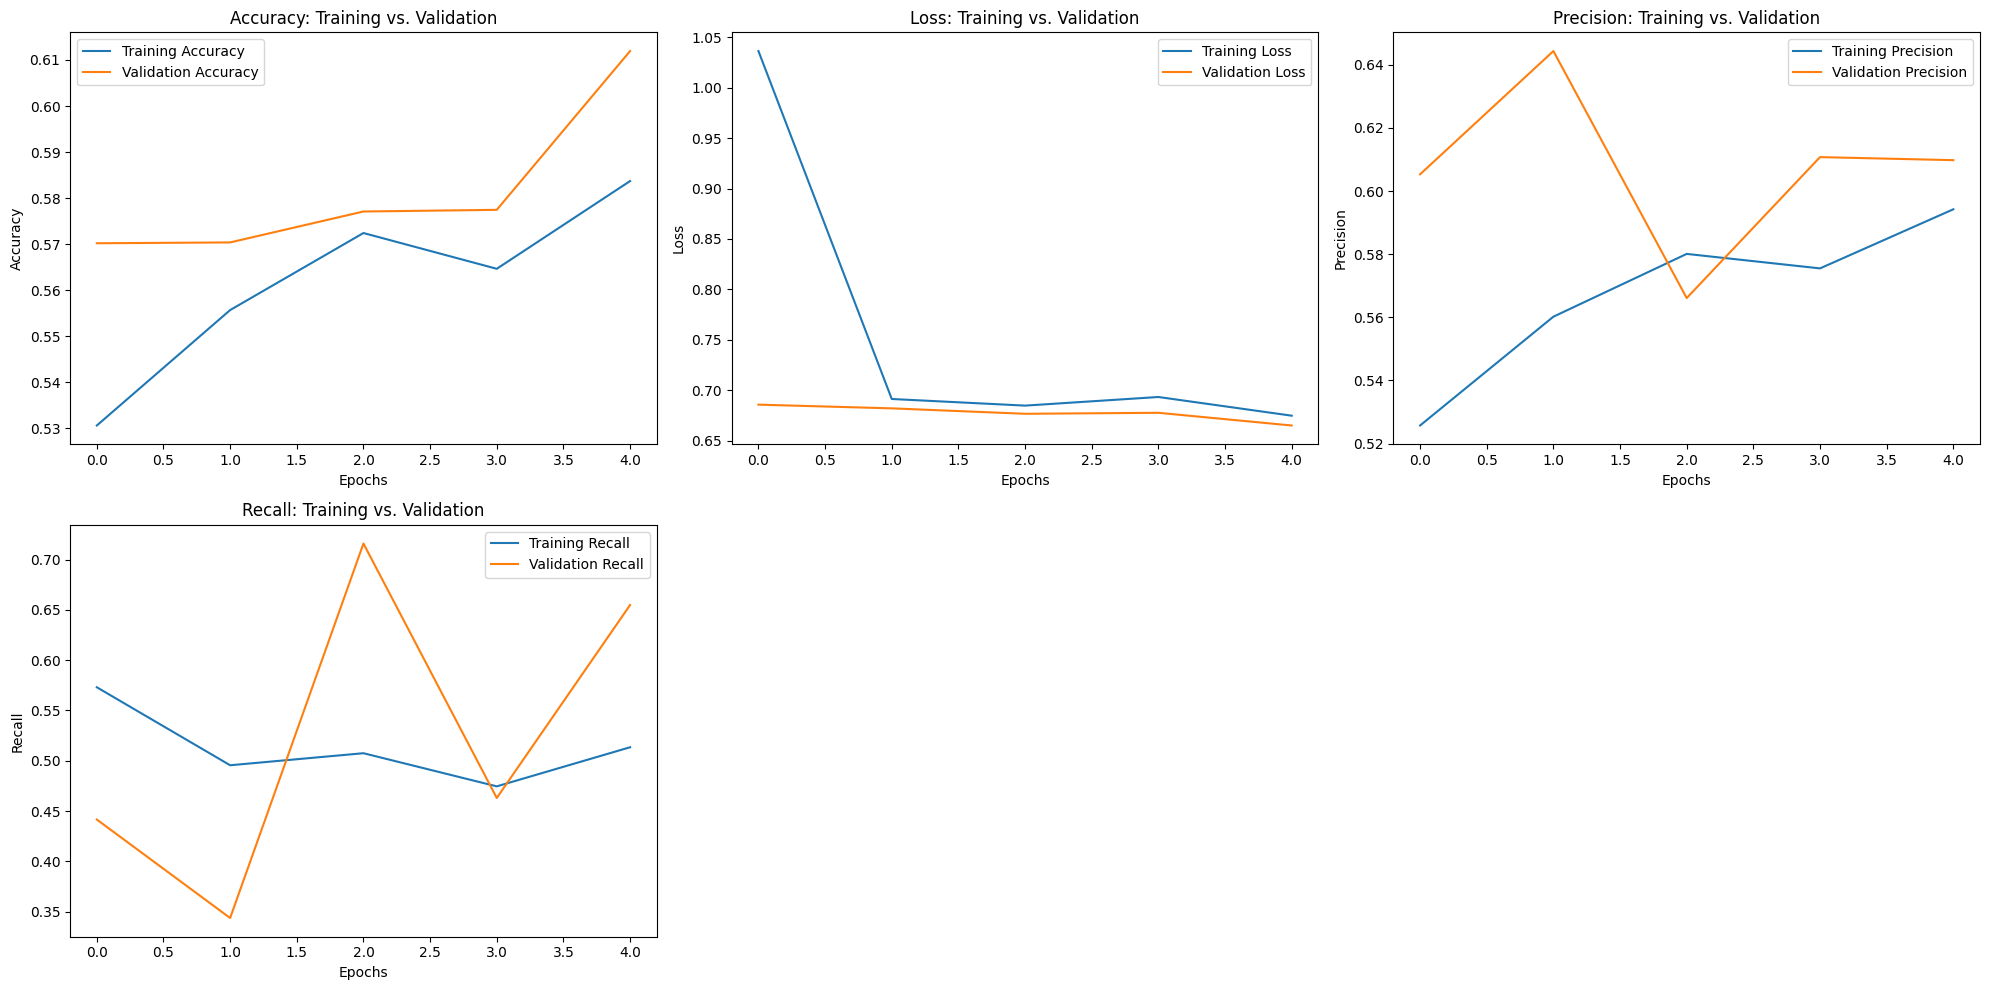

In [ ]:
cnn_model_history = cnn_model(df, train, test, my_callbacks)
plot_model_performance_metrics(cnn_model_history)

**ResNet Model**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

def resnet_model(df, train, test, my_callbacks):
    x_train = img_datagen.flow_from_dataframe(
        dataframe = train,
        x_col = 'Image_Path',
        y_col = 'Labels',
        class_mode = 'binary',
        target_size = (224, 224),
        shuffle = True,
        batch_size = 10,
        seed = 10,
        subset = 'training')

    x_test = img_datagen.flow_from_dataframe(
        dataframe = test,
        x_col = 'Image_Path',
        y_col = 'Labels',
        class_mode = 'binary',
        target_size = (224, 224),
        shuffle = False,
        batch_size = 10,
        seed = 10)

    resnet_base = ResNet50(weights = 'imagenet',
                           include_top = False,
                           input_shape = (224, 224, 3))

    for layer in resnet_base.layers:
        layer.trainable = False

    model = Sequential([
        resnet_base,
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dropout(0.5),
        Dense(1, activation = 'sigmoid')
    ])

    model.compile(optimizer = RMSprop(lr=1e-4),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy',
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.Recall()])

    resnet_model_history = model.fit(
        x_train,
        steps_per_epoch = len(x_train),
        epochs = 5,
        validation_data = x_test,
        validation_steps = len(x_test),
        callbacks = my_callbacks)

    return resnet_model_history

Found 17637 validated image filenames belonging to 2 classes.
Found 5512 validated image filenames belonging to 2 classes.
94765736/94765736 [==============================] - 1s 0us/step


Epoch 1/5
1764/1764 [==============================] - 358s 200ms/step - loss: 4.5248 - accuracy: 0.8229 - precision_1: 0.8224 - recall_1: 0.8213 - val_loss: 0.4900 - val_accuracy: 0.8832 - val_precision_1: 0.9385 - val_recall_1: 0.8239
Epoch 2/5
1764/1764 [==============================] - 339s 192ms/step - loss: 0.4584 - accuracy: 0.8702 - precision_1: 0.8716 - recall_1: 0.8666 - val_loss: 0.2678 - val_accuracy: 0.9097 - val_precision_1: 0.9099 - val_recall_1: 0.9125
Epoch 3/5
1764/1764 [==============================] - 346s 196ms/step - loss: 0.3918 - accuracy: 0.8898 - precision_1: 0.8949 - recall_1: 0.8819 - val_loss: 0.2721 - val_accuracy: 0.9126 - val_precision_1: 0.8899 - val_recall_1: 0.9446
Epoch 4/5
1764/1764 [==============================] - 346s 196ms/step - loss: 0.3466 - accuracy: 0.8954 - precision_1: 0.9005 - recall_1: 0.8878 - val_loss: 0.3171 - val_accuracy: 0.9202 - val_precision_1: 0.9134 - val_recall_1: 0.9310


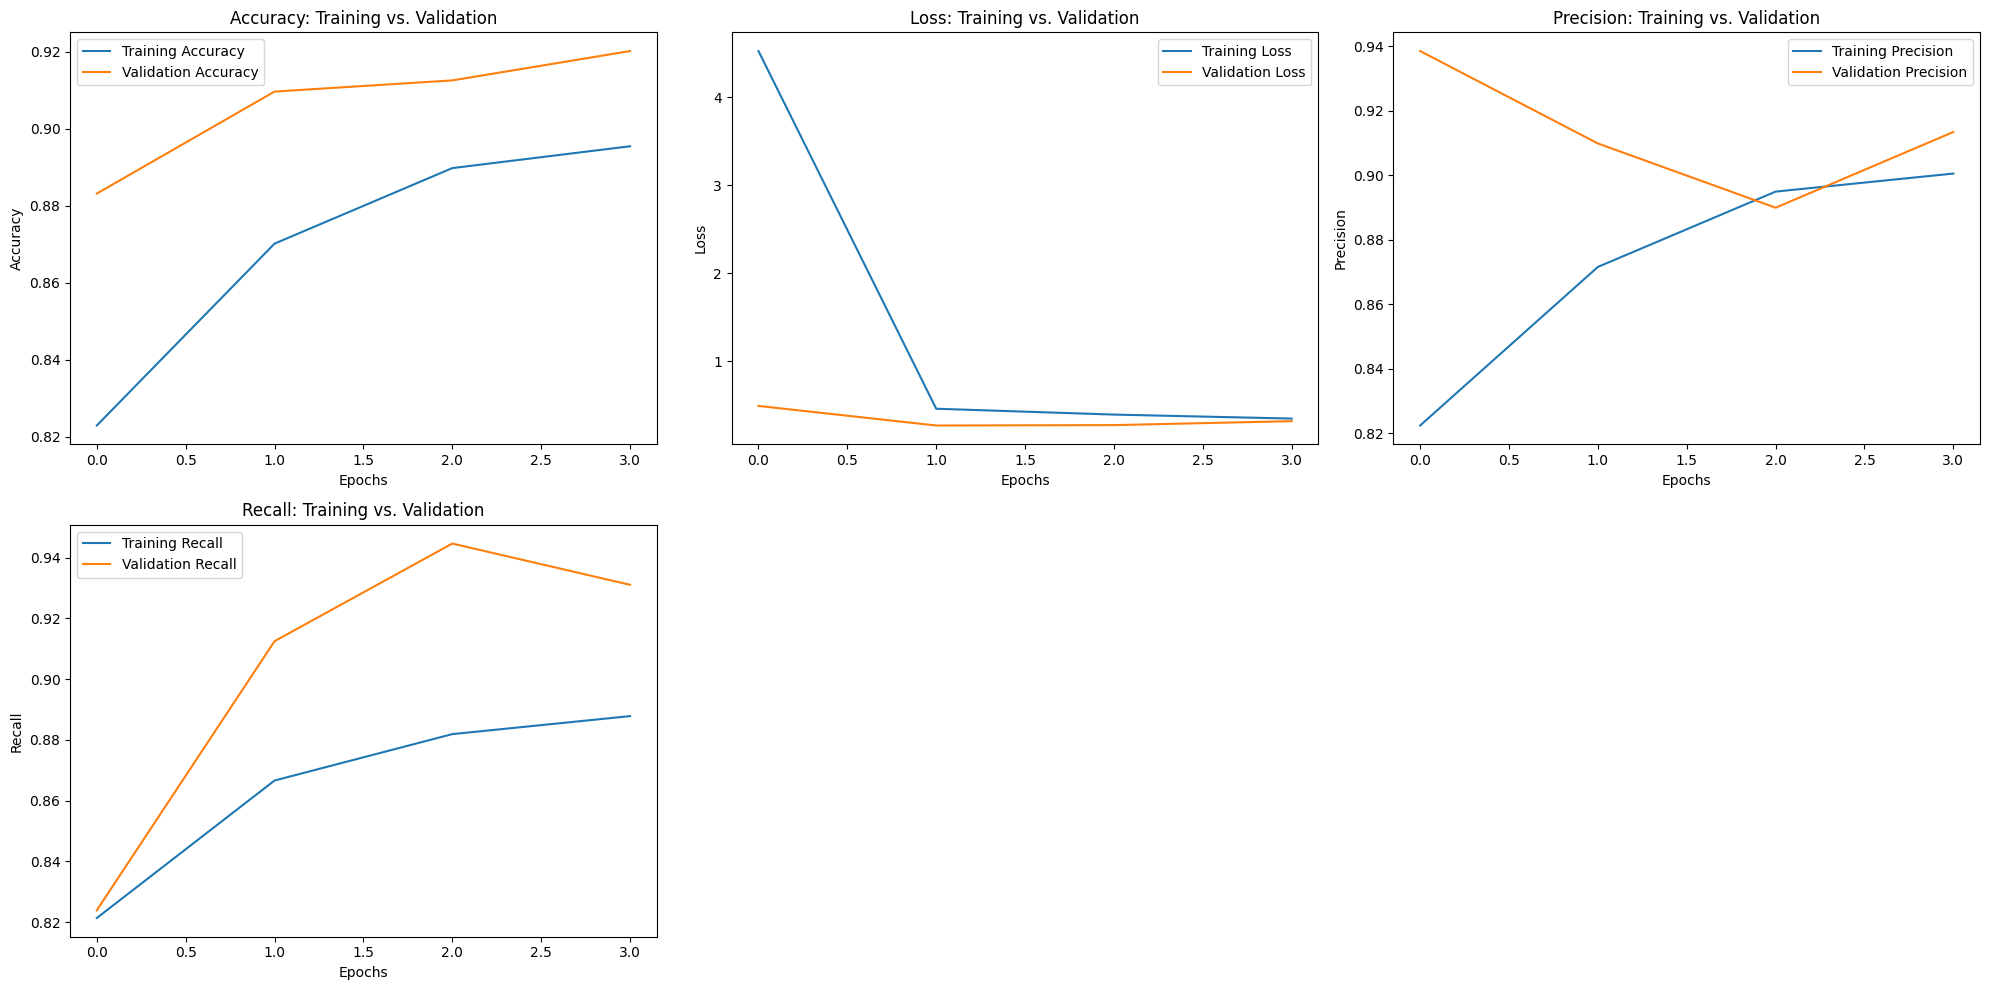

In [ ]:
resnet_model_history = resnet_model(df, train, test, my_callbacks)
plot_model_performance_metrics(resnet_model_history)

**VGG Model**

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

def vgg_model(df, train, test, my_callbacks):
    x_train = img_datagen.flow_from_dataframe(
        dataframe = train,
        x_col = 'Image_Path',
        y_col = 'Labels',
        target_size = (224, 224),
        class_mode = 'binary',
        batch_size = 10,
        shuffle = True,
        seed = 10,
        subset = 'training'
    )

    x_test = img_datagen.flow_from_dataframe(
        dataframe = test,
        x_col = 'Image_Path',
        y_col = 'Labels',
        target_size = (224, 224),
        class_mode = 'binary',
        batch_size = 10,
        shuffle = False,
        seed = 10,
        subset = 'validation'
    )

    vgg_base = VGG19(weights = 'imagenet',
                     include_top = False,
                     input_shape = (224, 224, 3))

    for layer in vgg_base.layers:
        layer.trainable = False

    model = Sequential([
        vgg_base,
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dropout(0.5),
        Dense(1, activation = 'sigmoid')
    ])

    model.compile(optimizer = RMSprop(lr=1e-4),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()])

    vgg_model_history = model.fit(
        x_train,
        steps_per_epoch = len(x_train),
        validation_data = x_test,
        validation_steps = len(x_test),
        epochs = 5,
        callbacks = my_callbacks
    )

    return vgg_model_history

Found 17637 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
80134624/80134624 [==============================] - 0s 0us/step


Epoch 1/5
1764/1764 [==============================] - 290s 162ms/step - loss: 4.0989 - accuracy: 0.8464 - precision_2: 0.8444 - recall_2: 0.8472 - val_loss: 0.4476 - val_accuracy: 0.9020 - val_precision_2: 0.8583 - val_recall_2: 0.9638
Epoch 2/5
1764/1764 [==============================] - 278s 158ms/step - loss: 0.4425 - accuracy: 0.8937 - precision_2: 0.8878 - recall_2: 0.8999 - val_loss: 0.2931 - val_accuracy: 0.9165 - val_precision_2: 0.8954 - val_recall_2: 0.9439
Epoch 3/5
1764/1764 [==============================] - 278s 158ms/step - loss: 0.4240 - accuracy: 0.9063 - precision_2: 0.9041 - recall_2: 0.9078 - val_loss: 0.3187 - val_accuracy: 0.9356 - val_precision_2: 0.9228 - val_recall_2: 0.9512
Epoch 4/5
1764/1764 [==============================] - 280s 158ms/step - loss: 0.3926 - accuracy: 0.9088 - precision_2: 0.9009 - recall_2: 0.9176 - val_loss: 0.2868 - val_accuracy: 0.9183 - val_precision_2: 0.9279 - val_recall_2: 0.9078
Epoch 5/5
1764/1764 [==============================]

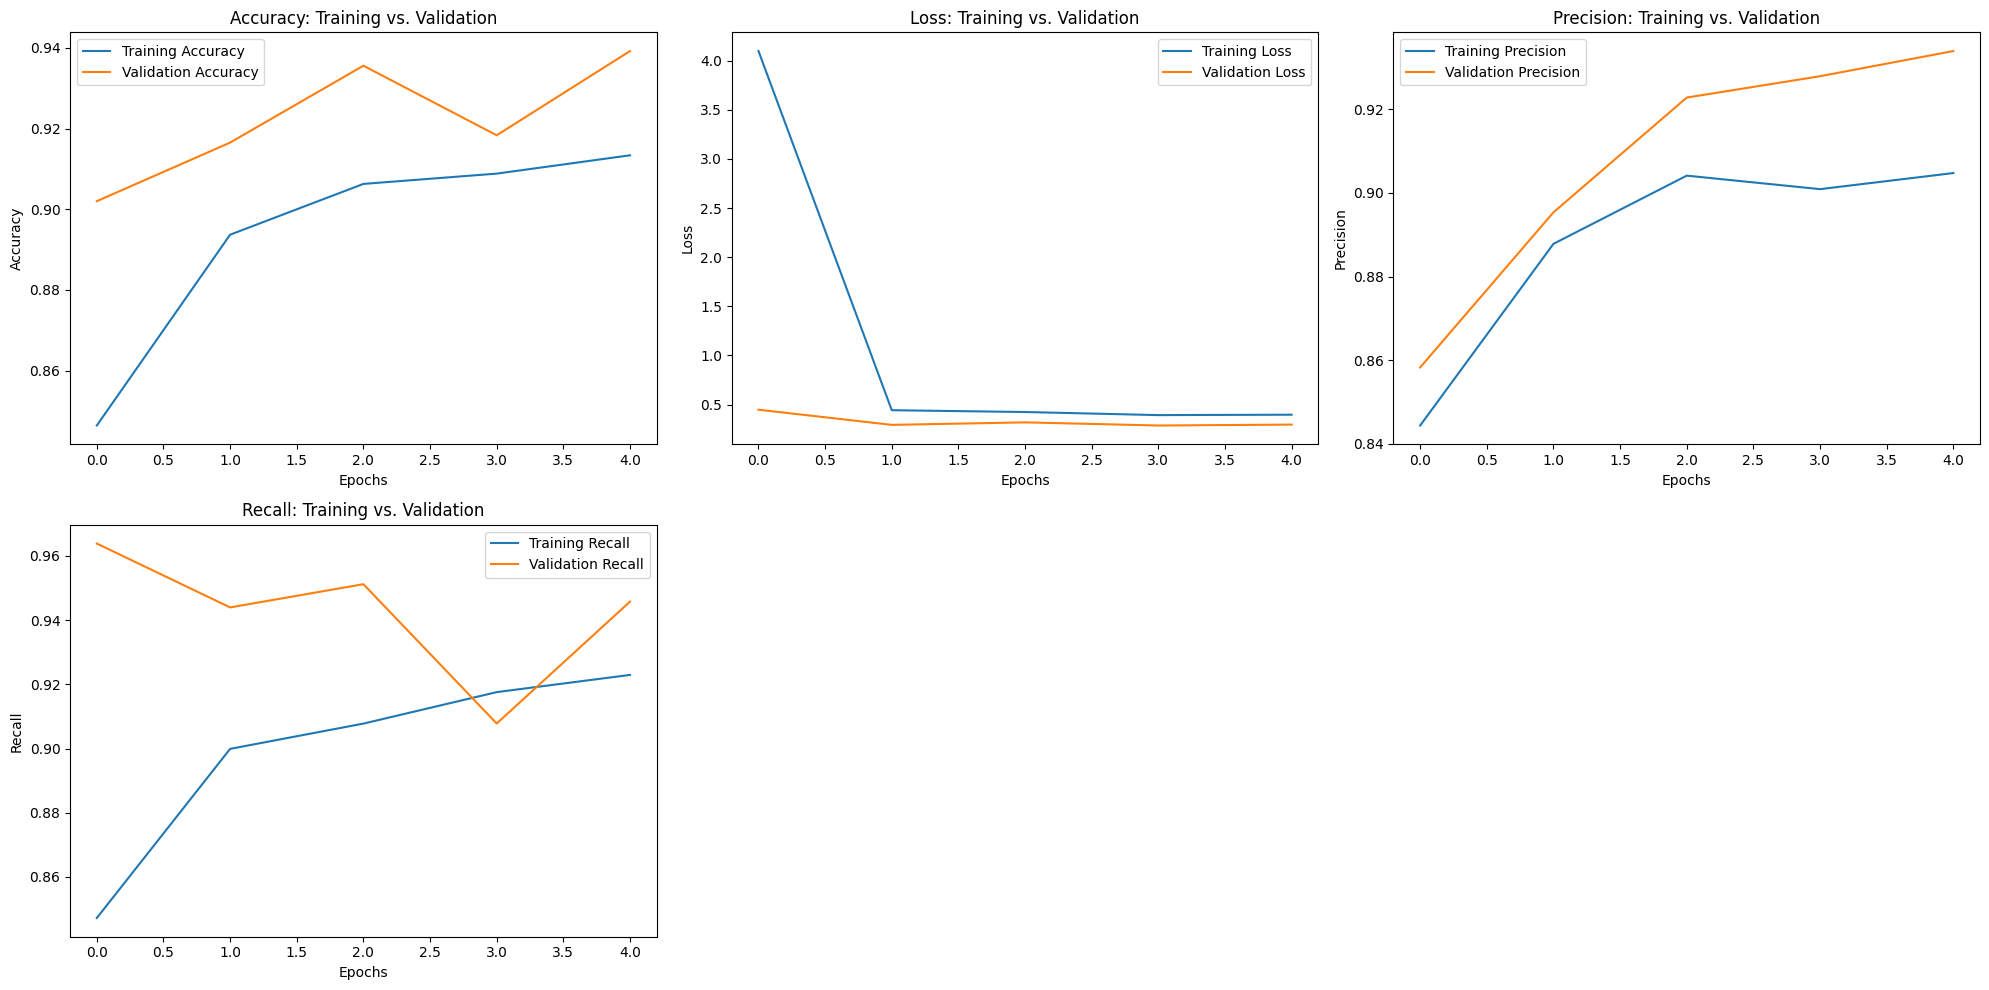

In [ ]:
vgg_model_history = vgg_model(df, train, test, my_callbacks)
plot_model_performance_metrics(vgg_model_history)

**Inception Model**

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

def inception_model(df, train, test, my_callbacks):
    x_train = img_datagen.flow_from_dataframe(
        dataframe = train,
        x_col = 'Image_Path',
        y_col = 'Labels',
        target_size = (299, 299),
        class_mode = 'binary',
        batch_size = 10,
        shuffle = True,
        seed = 10,
        subset = 'training'
    )

    x_test = img_datagen.flow_from_dataframe(
        dataframe=test,
        x_col = 'Image_Path',
        y_col = 'Labels',
        target_size = (299, 299),
        class_mode = 'binary',
        batch_size = 10,
        shuffle = False,
        seed = 10
    )

    inception_base = InceptionV3(weights = 'imagenet',
                                 include_top = False,
                                 input_shape = (299, 299, 3))

    for layer in inception_base.layers:
        layer.trainable = False

    model = Sequential([
        inception_base,
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dropout(0.5),
        Dense(1, activation = 'sigmoid')
    ])

    model.compile(optimizer = RMSprop(lr=1e-4),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()])

    inception_model_history = model.fit(
        x_train,
        steps_per_epoch = len(x_train),
        epochs = 5,
        validation_data = x_test,
        validation_steps = len(x_test),
        callbacks = my_callbacks
    )

    return inception_model_history

Found 17637 validated image filenames belonging to 2 classes.
Found 5512 validated image filenames belonging to 2 classes.
87910968/87910968 [==============================] - 1s 0us/step


Epoch 1/5
1764/1764 [==============================] - 579s 324ms/step - loss: 57.1635 - accuracy: 0.5164 - precision_3: 0.5467 - recall_3: 0.1609 - val_loss: 0.6950 - val_accuracy: 0.4949 - val_precision_3: 0.7586 - val_recall_3: 0.0079
Epoch 2/5
1764/1764 [==============================] - 564s 320ms/step - loss: 0.9417 - accuracy: 0.5043 - precision_3: 0.6489 - recall_3: 0.0070 - val_loss: 0.6926 - val_accuracy: 0.4933 - val_precision_3: 1.0000 - val_recall_3: 0.0021
Epoch 3/5
1764/1764 [==============================] - 560s 318ms/step - loss: 0.8211 - accuracy: 0.4986 - precision_3: 0.4939 - recall_3: 0.3424 - val_loss: 0.6931 - val_accuracy: 0.4926 - val_precision_3: 0.7500 - val_recall_3: 0.0011
Epoch 4/5
1764/1764 [==============================] - 572s 324ms/step - loss: 0.7217 - accuracy: 0.5006 - precision_3: 0.4958 - recall_3: 0.2580 - val_loss: 0.6927 - val_accuracy: 0.4984 - val_precision_3: 0.6932 - val_recall_3: 0.0218


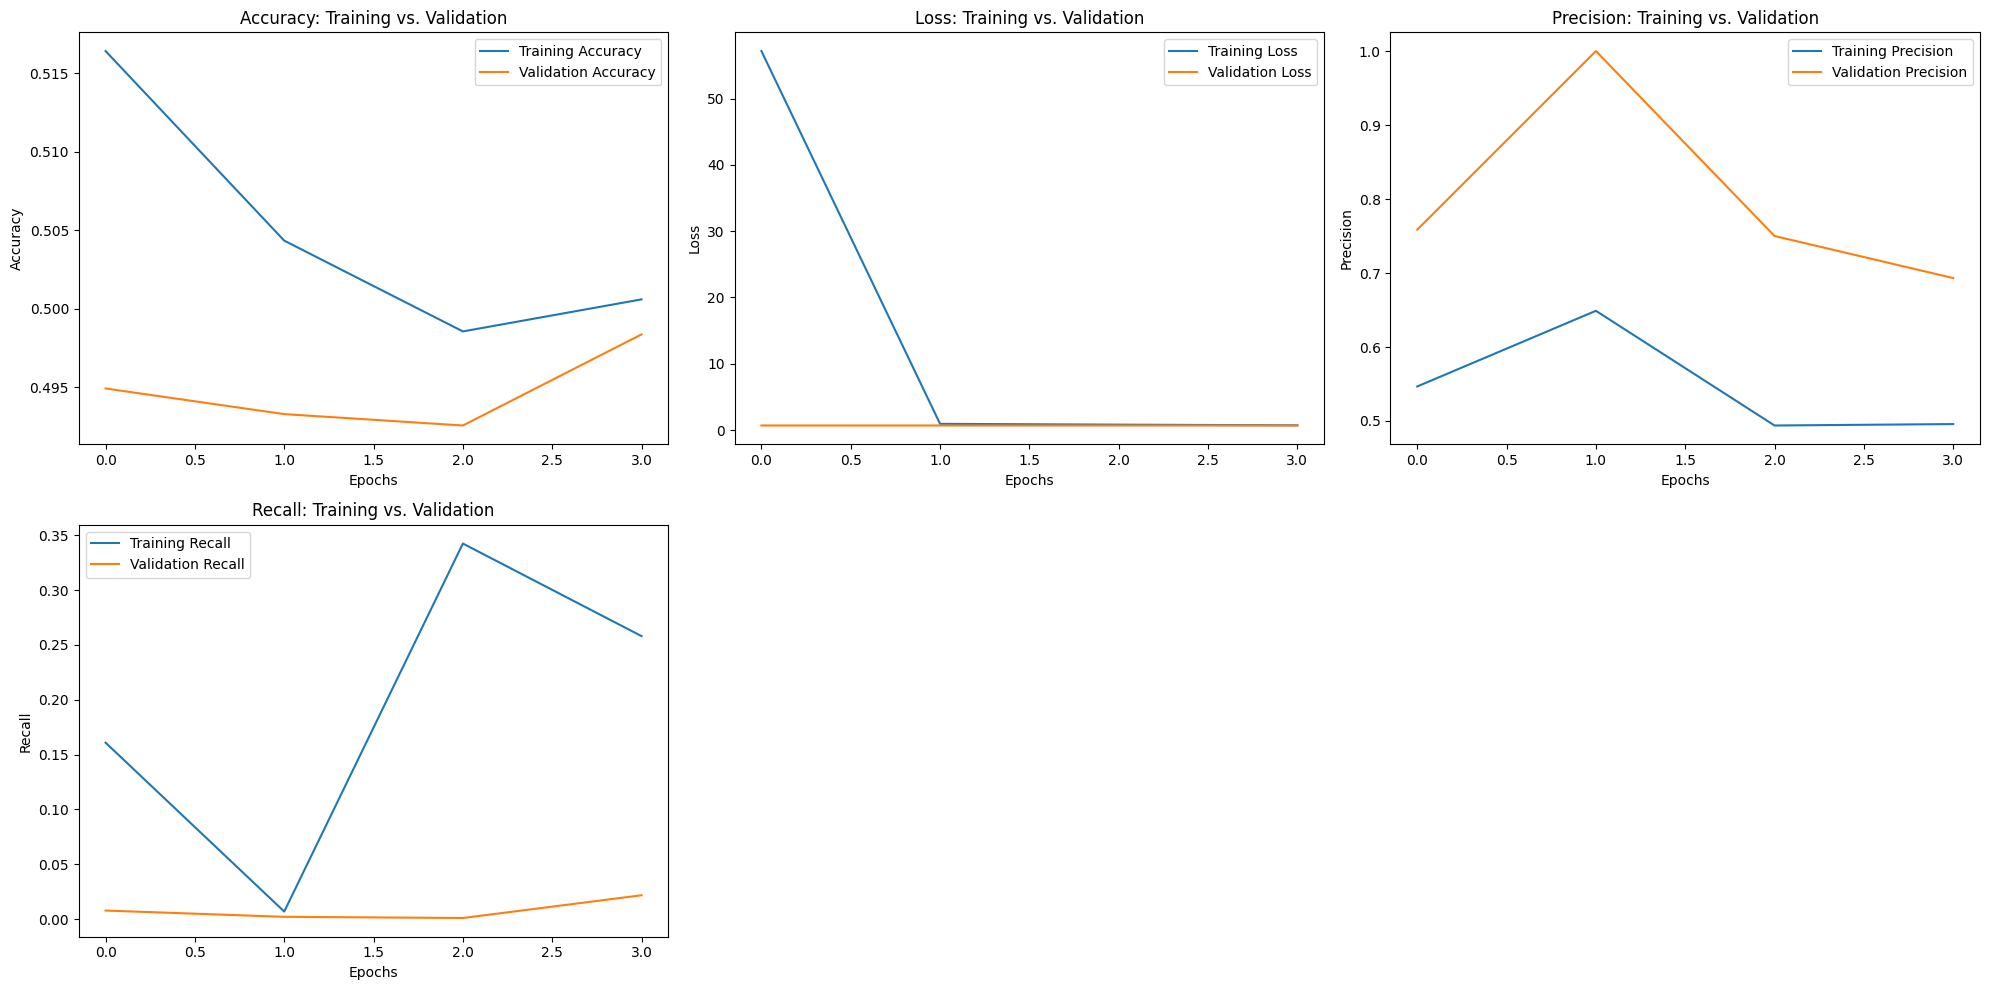

In [ ]:
inception_model_history = inception_model(df, train, test, my_callbacks)
plot_model_performance_metrics(inception_model_history)

**Performance Evaluation and Model Selection**

In [ ]:
pip install tabulate

In [ ]:
from tabulate import tabulate

model_histories = {
    'CNN Model': cnn_model_history,
    'VGG Model': vgg_model_history,
    'ResNet Model': resnet_model_history,
    'Inception Model': inception_model_history,
}

def get_final_metrics(history):
    metrics = history.history
    last_epoch = len(metrics['loss']) - 1
    results = {
        'Loss': metrics.get('loss')[last_epoch] if 'loss' in metrics else None,
        'Accuracy': metrics.get('accuracy')[last_epoch] if 'accuracy' in metrics else None,
        'Precision': metrics.get(next((k for k in metrics if 'precision' in k), None))[last_epoch] if any('precision' in k for k in metrics) else None,
        'Recall': metrics.get(next((k for k in metrics if 'recall' in k), None))[last_epoch] if any('recall' in k for k in metrics) else None,
        'Val Loss': metrics.get('val_loss')[last_epoch] if 'val_loss' in metrics else None,
        'Val Accuracy': metrics.get('val_accuracy')[last_epoch] if 'val_accuracy' in metrics else None,
        'Val Precision': metrics.get(next((k for k in metrics if 'val_precision' in k), None))[last_epoch] if any('val_precision' in k for k in metrics) else None,
        'Val Recall': metrics.get(next((k for k in metrics if 'val_recall' in k), None))[last_epoch] if any('val_recall' in k for k in metrics) else None,
    }
    return results

final_metrics = {model_name: get_final_metrics(history) for model_name, history in model_histories.items()}

data_for_tabulation = []
for model_name, metrics in final_metrics.items():
    row = [model_name]
    for key in ['Loss', 'Accuracy', 'Precision', 'Recall', 'Val Loss', 'Val Accuracy', 'Val Precision', 'Val Recall']:
        if key in ['Accuracy', 'Precision', 'Recall', 'Val Accuracy', 'Val Precision', 'Val Recall'] and metrics[key] is not None:
            row.append(f"{metrics[key] * 100:.2f}%")
        elif metrics[key] is not None:
            row.append(f"{metrics[key]:.3f}")
        else:
            row.append("N/A")
    data_for_tabulation.append(row)

headers = ["Model", "Loss", "Accuracy", "Precision", "Recall", "Val Loss",
           "Val Accuracy", "Val Precision", "Val Recall"]

table = tabulate(data_for_tabulation, headers=headers, tablefmt="fancy_grid")

print(table)

╒═════════════════╤════════╤════════════╤═════════════╤══════════╤════════════╤════════════════╤═════════════════╤══════════════╕
│ Model           │   Loss │ Accuracy   │ Precision   │ Recall   │   Val Loss │ Val Accuracy   │ Val Precision   │ Val Recall   │
╞═════════════════╪════════╪════════════╪═════════════╪══════════╪════════════╪════════════════╪═════════════════╪══════════════╡
│ CNN Model       │  0.675 │ 58.37%     │ 59.42%      │ 51.35%   │      0.665 │ 61.19%         │ 60.98%          │ 65.49%       │
├─────────────────┼────────┼────────────┼─────────────┼──────────┼────────────┼────────────────┼─────────────────┼──────────────┤
│ VGG Model       │  0.397 │ 91.34%     │ 90.48%      │ 92.29%   │      0.296 │ 93.92%         │ 93.39%          │ 94.58%       │
├─────────────────┼────────┼────────────┼─────────────┼──────────┼────────────┼────────────────┼─────────────────┼──────────────┤
│ ResNet Model    │  0.347 │ 89.54%     │ 90.05%      │ 88.78%   │      0.317 │ 92.02%    

## **Best Model:**

**The VGG Model has been selected as the best model** due to its:

* Exceptionally high precision and recall values, indicating reliable positive prediction and minimal false negatives.
* Superior balance between bias and variance as reflected in its consistent performance across both training and validation sets.
* Relatively quick execution time considering its deep architecture and complexity.
* Outstanding accuracy, showcasing its robustness and effectiveness for the task at hand.





